### Import

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import re
from skimage.metrics import peak_signal_noise_ratio as compare_psnr, structural_similarity as compare_ssim

### HELPER FUCTION

In [2]:
# Fungsi untuk mengubah text menjadi bit
def text_to_bits(text):
    return ''.join(format(ord(c), '08b') for c in text)

# Fungsi untuk mengubah bit menjadi text
def bits_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        chars.append(chr(int(byte, 2)))
    return ''.join(chars)

### Esktrak Hasil LSB dari Citra

In [3]:
def extract_lsb(image_path):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"gagal membaca gambar: {image_path}")
        return None
    
    # Flatten image
    flat = img.flatten()
    total = len(flat)

    # Baca header (32 bit)
    header_bits = ""
    for i in range(32):
        header_bits += str(flat[i] & 1)

    msg_len = int(header_bits, 2)

    # msg_len <= 0, maka tidak valid
    if msg_len <= 0:
        return "(Invalid payload)"

    # kapasitas minimal, yaitu 32 header + msg_len
    if 32 + msg_len > total:
        return "(Invalid payload)"

    bits = ""
    end = 32 + msg_len

    for i in range(32, end):
        bits += str(flat[i] & 1)

    # Jika bits kurang, maka corrupted
    if len(bits) != msg_len:
        return "(Corrupted payload)"

    return bits_to_text(bits)

### Fungsi BER (Bit Error Rate)

In [4]:
def bit_error_rate(original, extracted):
    if len(original) == 0:
        return 1.0
    min_len = min(len(original), len(extracted))
    diff = sum(o != e for o, e in zip(original[:min_len], extracted[:min_len]))
    return diff / min_len

### Simpan citra stego ke format JPEG dengan kualitas tertentu

In [5]:
def compress_jpeg(input_path, output_path, quality):
    img = cv2.imread(input_path)
    cv2.imwrite(output_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])

### Fungsi Uji Kompresi

In [6]:
def uji_kompresi(folder_stego, folder_out, kualitas_list=[90, 50, 10]):
    # Buat folder utama & subfolder
    folder_jpeg = os.path.join(folder_out, "jpeg")
    folder_reconv = os.path.join(folder_out, "reconverted")
    os.makedirs(folder_jpeg, exist_ok=True)
    os.makedirs(folder_reconv, exist_ok=True)

    hasil = []

    for filename in os.listdir(folder_stego):
        if not filename.lower().endswith(".png"):
            continue

        path_stego = os.path.join(folder_stego, filename)
        name = os.path.splitext(filename)[0]

        # Ekstrak pesan asli dari citra stego
        original_msg = extract_lsb(path_stego)
        original_bits = text_to_bits(original_msg)

        for q in kualitas_list:
            out_jpeg = os.path.join(folder_jpeg, f"{name}_q{q}.jpg")
            out_recovered_png = os.path.join(folder_reconv, f"{name}_q{q}_reconv.png")

            # Simpan versi terkompresi JPEG
            compress_jpeg(path_stego, out_jpeg, q)

            # Baca kembali JPEG → simpan ulang ke PNG
            img_jpeg = cv2.imread(out_jpeg)
            cv2.imwrite(out_recovered_png, img_jpeg)

            # Ekstrak pesan dari hasil konversi PNG
            extracted_msg = extract_lsb(out_recovered_png)
            extracted_bits = text_to_bits(extracted_msg)

            # Hitung BER
            ber = bit_error_rate(original_bits, extracted_bits)

            # Hitung PSNR & SSIM
            img_orig = cv2.imread(path_stego)
            psnr_val = compare_psnr(img_orig, img_jpeg)
            ssim_val = compare_ssim(
                cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY),
                cv2.cvtColor(img_jpeg, cv2.COLOR_BGR2GRAY)
            )

            hasil.append((filename, q, psnr_val, ssim_val, ber))

            print(f"{filename} | Q={q} → PSNR={psnr_val:.2f}, SSIM={ssim_val:.3f}, BER={ber:.4f}")

    return hasil

### Eksekusi Uji Kompresi

In [7]:
hasil_kompresi = uji_kompresi(
    folder_stego="stego_batik",
    folder_out="compression_batik",
    kualitas_list=[90, 50, 10]
)

stego_1.png | Q=90 → PSNR=35.93, SSIM=0.997, BER=0.3382
stego_1.png | Q=50 → PSNR=27.54, SSIM=0.940, BER=0.3382
stego_1.png | Q=10 → PSNR=22.72, SSIM=0.831, BER=0.3382
stego_10.png | Q=90 → PSNR=32.27, SSIM=0.996, BER=0.3382
stego_10.png | Q=50 → PSNR=24.55, SSIM=0.956, BER=0.3382
stego_10.png | Q=10 → PSNR=18.94, SSIM=0.823, BER=0.3382
stego_11.png | Q=90 → PSNR=45.56, SSIM=0.999, BER=0.3382
stego_11.png | Q=50 → PSNR=29.30, SSIM=0.952, BER=0.3382
stego_11.png | Q=10 → PSNR=24.24, SSIM=0.870, BER=0.3382
stego_12.png | Q=90 → PSNR=48.48, SSIM=1.000, BER=0.3382
stego_12.png | Q=50 → PSNR=36.05, SSIM=0.977, BER=0.3382
stego_12.png | Q=10 → PSNR=27.29, SSIM=0.877, BER=0.3750
stego_13.png | Q=90 → PSNR=46.84, SSIM=1.000, BER=0.3382
stego_13.png | Q=50 → PSNR=33.19, SSIM=0.981, BER=0.3382
stego_13.png | Q=10 → PSNR=24.63, SSIM=0.880, BER=0.3382
stego_14.png | Q=90 → PSNR=45.61, SSIM=0.999, BER=0.3382
stego_14.png | Q=50 → PSNR=35.39, SSIM=0.989, BER=0.3382
stego_14.png | Q=10 → PSNR=27.29, 

### Visualisasi Hasil

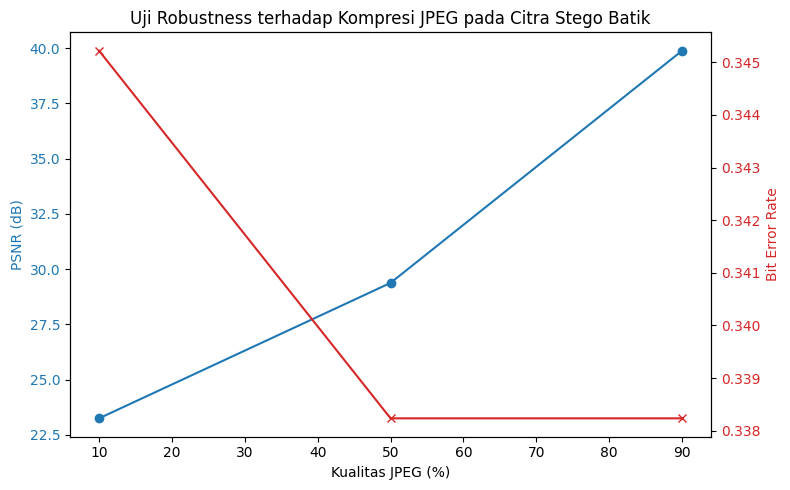


Rata-rata hasil per tingkat kualitas:


,Kualitas_JPEG,PSNR,SSIM,BER
0,10,23.246720,0.831470,0.345219
1,50,29.376976,0.951339,0.338235
2,90,39.884990,0.996301,0.338235


In [8]:
df = pd.DataFrame(hasil_kompresi, columns=["File", "Kualitas_JPEG", "PSNR", "SSIM", "BER"])

# Hitung rata-rata untuk setiap level kualitas
avg = df.groupby("Kualitas_JPEG")[["PSNR", "SSIM", "BER"]].mean().reset_index()

# Plot PSNR dan BER
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(avg["Kualitas_JPEG"], avg["PSNR"], marker='o', color='tab:blue', label="PSNR (dB)")
ax1.set_xlabel("Kualitas JPEG (%)")
ax1.set_ylabel("PSNR (dB)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(avg["Kualitas_JPEG"], avg["BER"], marker='x', color='tab:red', label="BER")
ax2.set_ylabel("Bit Error Rate", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Uji Robustness terhadap Kompresi JPEG pada Citra Stego Batik")
fig.tight_layout()
plt.show()

print("\nRata-rata hasil per tingkat kualitas:")
display(avg)

In [ ]:
os.makedirs("robustness_results", exist_ok=True)
csv_path = os.path.join("robustness_results", "jpeg_compression_metrics.csv")

with open(csv_path, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["File", "Kualitas JPEG", "PSNR (dB)", "SSIM", "BER", "Extracted Snippet"])

print("\n=== HASIL EKSTRAKSI PESAN (KOMPRESI JPEG) ===")

# Folder hasil konversi PNG (bukan JPEG)
folder_reconv = os.path.join("compression_batik", "reconverted")

def numeric_sort(filename):
    nums = re.findall(r'\d+', filename)
    return int(nums[0]) if nums else 0

for filename in sorted(os.listdir(folder_reconv), key=numeric_sort):
    if filename.lower().endswith("_reconv.png"):
        path_extracted = os.path.join(folder_reconv, filename)
        extracted_msg = extract_lsb(path_extracted)
        snippet = extracted_msg[:200] + "..." if len(extracted_msg) > 200 else extracted_msg

        base_name = filename.split("_q")[0] + ".png"
        q_value = int(filename.split("_q")[1].split("_")[0])

        row = df[(df["File"] == base_name) & (df["Kualitas_JPEG"] == q_value)]
        if not row.empty:
            psnr_val = float(row["PSNR"].values[0])
            ssim_val = float(row["SSIM"].values[0])
            ber_val = float(row["BER"].values[0])
        else:
            psnr_val = ssim_val = ber_val = None

        print(f"\nFile: {base_name} | Q={q_value}")
        print(f"PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.3f} | BER: {ber_val:.6f}")
        print("Extracted snippet:")
        print("------------------------------------------------------------")
        print(snippet)
        print("------------------------------------------------------------\n")

        with open(csv_path, mode="a", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow([base_name, q_value, f"{psnr_val:.2f}", f"{ssim_val:.3f}", f"{ber_val:.6f}", snippet])


=== HASIL EKSTRAKSI PESAN (KOMPRESI JPEG) ===


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'uji_kompresi\\reconverted'